In [1]:
from Datos import Datos
from ModeloPINN import ModeloPINN
import numpy as np
import pandas as pd
import torch

In [2]:
modelo = ModeloPINN('sistema_solar.csv',['mercurio','venus','tierra','marte','jupiter','saturno','urano','neptuno'], device='cpu')

In [3]:
modelo.posiciones_velocidades(obj='tierra')
modelo.escalar_y_transformar()
modelo.particionar_datos(tam_test=0.2, batch_size=64)

In [4]:
modelo.construir_red(neuronas=[1+8*3,128,128,128,64,32,16,3])
modelo.optimizar_red(paciencia = 35, min_lr=1e-6)

In [5]:
historial = modelo.validacion_cruzada(k=5, epochs=1000,batch_size=32, early=100)


Fold 1/5
Ep    1 -> Train 9.266e-01, Val 2.385e-01
Ep    2 -> Train 2.158e-01, Val 2.049e-01
Ep    3 -> Train 1.985e-01, Val 1.980e-01
Ep    4 -> Train 1.940e-01, Val 1.951e-01
Ep    5 -> Train 1.933e-01, Val 1.948e-01
Ep    6 -> Train 1.925e-01, Val 1.958e-01
Ep    7 -> Train 1.930e-01, Val 1.957e-01
Ep    8 -> Train 1.928e-01, Val 1.960e-01
Ep    9 -> Train 1.920e-01, Val 1.961e-01
Ep   10 -> Train 1.919e-01, Val 1.968e-01
Ep   11 -> Train 1.916e-01, Val 1.945e-01
Ep   12 -> Train 1.910e-01, Val 1.979e-01
Ep   13 -> Train 1.917e-01, Val 1.965e-01
Ep   14 -> Train 1.912e-01, Val 1.972e-01
Ep   15 -> Train 1.910e-01, Val 2.020e-01
Ep   16 -> Train 1.920e-01, Val 1.944e-01
Ep   17 -> Train 1.909e-01, Val 1.951e-01
Ep   18 -> Train 1.909e-01, Val 1.941e-01
Ep   19 -> Train 1.900e-01, Val 1.946e-01
Ep   20 -> Train 1.913e-01, Val 1.943e-01
Ep   21 -> Train 1.904e-01, Val 1.955e-01
Ep   22 -> Train 1.904e-01, Val 1.951e-01
Ep   23 -> Train 1.906e-01, Val 1.949e-01
Ep   24 -> Train 1.906e-

In [ ]:
modelo.modelo.eval()
with torch.no_grad():
    preds, targets = [], []
    for (t_b, pos_b), (r_b, _) in modelo.val_loader:
        t_b = t_b.to(modelo.disp)
        pos_b = pos_b.to(modelo.disp)
        r_b = r_b.to(modelo.disp)

        inp = torch.cat([t_b, pos_b.view(t_b.size(0), -1)], dim=1)
        r_pred = modelo.modelo(inp)

        preds.append(r_pred)
        targets.append(r_b)

    r_total = torch.cat(targets, dim=0)
    r_pred_total = torch.cat(preds, dim=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def calcular_metricas(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

metricas = calcular_metricas(r_total, r_pred_total)

print("\n📊 Métricas del modelo final:")
for k, v in metricas.items():
    print(f"{k}: {v:.5f}")

In [19]:
torch.save(modelo.modelo, 'modelo_nuevo_nuevo_nuevo.pth')

In [11]:
historial

[{'train_loss': [0.926640351112986,
   0.21579498433998243,
   0.1985007489654354,
   0.19403207713680465,
   0.19333426632719303,
   0.19246688188182925,
   0.19297164189890578,
   0.1928179238206747,
   0.19195521655937367,
   0.1918834111248667,
   0.19162158008849428,
   0.19095934289891264,
   0.1917387593813932,
   0.1911879355307641,
   0.19099897317957493,
   0.19196936480401153,
   0.19089859645317067,
   0.19085546100984818,
   0.18995705869812657,
   0.19128471474238953,
   0.19036371443831623,
   0.1903929782262933,
   0.19060889375950582,
   0.19055551239114704,
   0.1898801487103378,
   0.19033084196682795,
   0.19072998374855554,
   0.189994438369079,
   0.1905991209310406,
   0.1903293351669557,
   0.18995405088670606,
   0.19006921541044688,
   0.1897890635983049,
   0.18981471678148776,
   0.1899025204930278,
   0.19004929728567388,
   0.18957192430977882,
   0.1901583054230176,
   0.18969836231456727,
   0.18850693166207,
   0.188619235277078,
   0.188592708538305,
 

TypeError: list indices must be integers or slices, not str

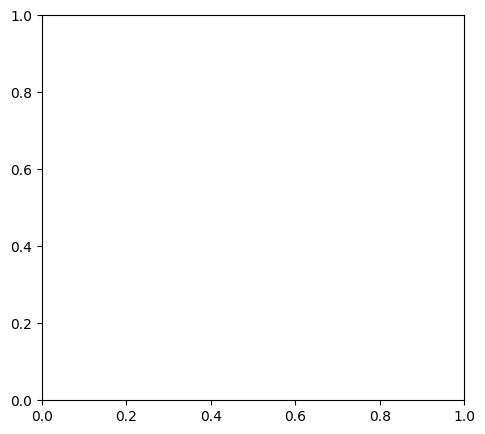

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Total loss
plt.subplot(1, 2, 1)
plt.plot(historial['train_loss'], label="Train total")
plt.plot(historial['val_loss'], label="Val total")
plt.title("Pérdida total")
plt.yscale('log')
plt.legend()

# Componentes físicas
plt.subplot(1, 2, 2)
plt.plot(historial['train_r'], label="Train r")
plt.plot(historial['train_v'], label="Train v")
plt.plot(historial['train_f'], label="Train física")
plt.title("Componentes de la pérdida (entrenamiento)")
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:

historial_fisica = modelo.refinar_con_fisica(epochs=1000, peso_fis=0.1, early=200)


🏋️ Refinamiento con pérdida física...
Ep    1 -> Train nan, Val nan


KeyboardInterrupt: 

In [3]:
df = modelo.datos.reset_index(drop=True)
t_np = df['t'].values[:10].reshape(-1,1).astype(np.float32)

N = len(df); p = modelo.num_planetas
pos_all = np.zeros((N,p, 3), dtype = np.float32)

for i,p in enumerate(['mercurio','venus','tierra','marte','jupiter','saturno','urano','neptuno']):
        pos_all[:,i,0] = df[f"{p}_x"]
        pos_all[:,i,1] = df[f"{p}_y"]
        pos_all[:,i,2] = df[f"{p}_z"]

pos_np = pos_all[:10]

r_pred = modelo.predecir(t_np, pos_np)
print("Primeras 10 predicciones (UA):\n", r_pred)

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [13]:
orbita = modelo.simular(inicio = "2025-01-01", dias_sim= 365, paso_dias=1)

print("Órbita simulada (365×3):", orbita.shape)

IndexError: index 2 is out of bounds for axis 1 with size 1

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(orbita[:, 0], orbita[:, 1], orbita[:, 2], label='Predicción órbita')
ax.set_title("Órbita simulada del cuerpo objetivo")
ax.set_xlabel("x (UA)")
ax.set_ylabel("y (UA)")
ax.set_zlabel("z (UA)")
ax.legend()
plt.show()



In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import torch

def calcular_metricas(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = r2_score(y_true, y_pred)
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}


In [ ]:
modelo = 

modelo.modelo.eval()
preds, targets = [], []

with torch.no_grad():
    for (t_b, pos_b), (r_b, _) in modelo.val_loader:
        t_b = t_b.to(modelo.disp)
        pos_b = pos_b.to(modelo.disp)
        r_b = r_b.to(modelo.disp)

        inp = torch.cat([t_b, pos_b.view(t_b.size(0), -1)], dim=1)
        r_pred = modelo.modelo(inp)

        preds.append(r_pred)
        targets.append(r_b)

pred_total = torch.cat(preds, dim=0)
target_total = torch.cat(targets, dim=0)

metricas = calcular_metricas(target_total, pred_total)

print("\n📊 Métricas post-entrenamiento (sin reentrenar):")
for k, v in metricas.items():
    print(f"{k}: {v:.5f}")



📊 Métricas post-entrenamiento (sin reentrenar):
RMSE: 0.00384
MAE: 0.00286
MAPE: 1.73898
R2: 0.99999


In [19]:
base = pd.read_csv('sistema_solar.csv')
base

,Unnamed: 0,fecha,mercurio_x,mercurio_y,mercurio_z,mercurio_vx,mercurio_vy,mercurio_vz,venus_x,venus_y,...,urano_z,urano_vx,urano_vy,urano_vz,neptuno_x,neptuno_y,neptuno_z,neptuno_vx,neptuno_vy,neptuno_vz
0,1,2000-01-01,-0.140728,-0.443901,-0.023346,0.021169,-0.007098,-0.002523,-0.718630,-0.022504,...,-0.238129,0.002678,0.002672,-0.000025,16.810758,-24.992651,0.127271,0.002579,0.001776,-0.000096
1,2,2000-01-02,-0.119364,-0.450348,-0.025833,0.021548,-0.005794,-0.002451,-0.717832,-0.042798,...,-0.238154,0.002678,0.002673,-0.000025,16.813337,-24.990875,0.127175,0.002579,0.001777,-0.000096
2,3,2000-01-03,-0.097653,-0.455484,-0.028245,0.021864,-0.004475,-0.002372,-0.716466,-0.063059,...,-0.238179,0.002677,0.002673,-0.000025,16.815915,-24.989098,0.127079,0.002579,0.001777,-0.000096
3,4,2000-01-04,-0.075657,-0.459294,-0.030576,0.022117,-0.003142,-0.002287,-0.714532,-0.083270,...,-0.238204,0.002677,0.002674,-0.000025,16.818494,-24.987320,0.126983,0.002579,0.001778,-0.000096
4,5,2000-01-05,-0.053441,-0.461765,-0.032817,0.022305,-0.001798,-0.002194,-0.712033,-0.103415,...,-0.238229,0.002676,0.002674,-0.000025,16.821073,-24.985542,0.126888,0.002579,0.001778,-0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9128,9129,2024-12-28,-0.394287,-0.058497,0.031384,-0.001721,-0.026621,-0.002018,0.513671,0.508359,...,-0.084399,-0.003272,0.002056,0.000050,29.879767,-0.646832,-0.675236,0.000040,0.003161,-0.000066
9129,9130,2024-12-29,-0.395106,-0.084965,0.029296,0.000071,-0.026296,-0.002155,0.499183,0.522448,...,-0.084349,-0.003273,0.002056,0.000050,29.879807,-0.643671,-0.675302,0.000040,0.003161,-0.000066
9130,9131,2024-12-30,-0.394168,-0.111056,0.027078,0.001793,-0.025869,-0.002279,0.484304,0.536127,...,-0.084298,-0.003273,0.002055,0.000050,29.879847,-0.640510,-0.675367,0.000040,0.003161,-0.000066
9131,9132,2024-12-31,-0.391544,-0.136672,0.024744,0.003445,-0.025348,-0.002387,0.469045,0.549387,...,-0.084248,-0.003273,0.002054,0.000050,29.879888,-0.637349,-0.675433,0.000040,0.003161,-0.000066
